![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/46.1.Multi_Modal_LLMs.ipynb)

 # Multi-Modal LLMs

## Colab Setup

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.5.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

params = {
    "spark.driver.memory":"100G",
    "spark.kryoserializer.buffer.max":"2000M",
    "spark.driver.maxResultSize":"2000M",
}

spark = sparknlp_jsl.start(license_keys['SECRET'],
                           params=params,
                           #gpu=True # if you have GPU
                           )

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 6.1.1
Spark NLP_JSL Version : 6.1.0


 # MedicalVisionLLM

**` MedicalVisionLLM`** is a groundbreaking addition to our model lineup that enhances the capabilities of large language models with visual understanding. This model is designed to process and analyze both text and images, making it ideal for tasks that require a comprehensive understanding of multimodal data. The **`MedicalVisionLLM`** is built on the latest advancements in multimodal AI, allowing it to interpret and generate responses based on visual inputs alongside textual information.

# Model List

| **Model Name**             | **Quantization Options**   | **Description**   |
| -------------------------- | -------------------------- | ----------------- |
| JSL_MedS_NER_VLM_3B_v1         | [q4](https://nlp.johnsnowlabs.com/2025/08/08/jsl_meds_vlm_3b_q8_v1_en.html), [q8](https://nlp.johnsnowlabs.com/2025/08/08/jsl_meds_vlm_3b_q4_v1_en.html), [q16](https://nlp.johnsnowlabs.com/2025/08/08/jsl_meds_vlm_3b_q16_v1_en.html) | Extract and link structured medical named entities |
| JSL_MedS_VLM_2B_v1         | [q4](https://nlp.johnsnowlabs.com/2025/08/08/jsl_meds_ner_vlm_2b_q4_v1_en.html), [q8](https://nlp.johnsnowlabs.com/2025/08/10/jsl_meds_ner_vlm_2b_q8_v1_en.html), [q16](https://nlp.johnsnowlabs.com/2025/08/10/jsl_meds_ner_vlm_2b_q16_v1_en.html) | Extract and link structured medical named entities |
| JSL_MedS_NER_VLM_2B_v2         | [q4](https://nlp.johnsnowlabs.com/2025/08/10/jsl_meds_ner_vlm_2b_q4_v2_en.html), [q8](https://nlp.johnsnowlabs.com/2025/08/10/jsl_meds_ner_vlm_2b_q8_v2_en.html), [q16](https://nlp.johnsnowlabs.com/2025/08/10/jsl_meds_ner_vlm_2b_q16_v2_en.html) | Extract and link structured medical named entities |

# Example Data

In [ ]:
!mkdir -p images

!wget -O images/prescription.png  -q "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/healthcare-nlp/data/ocr/prescription_02.png"


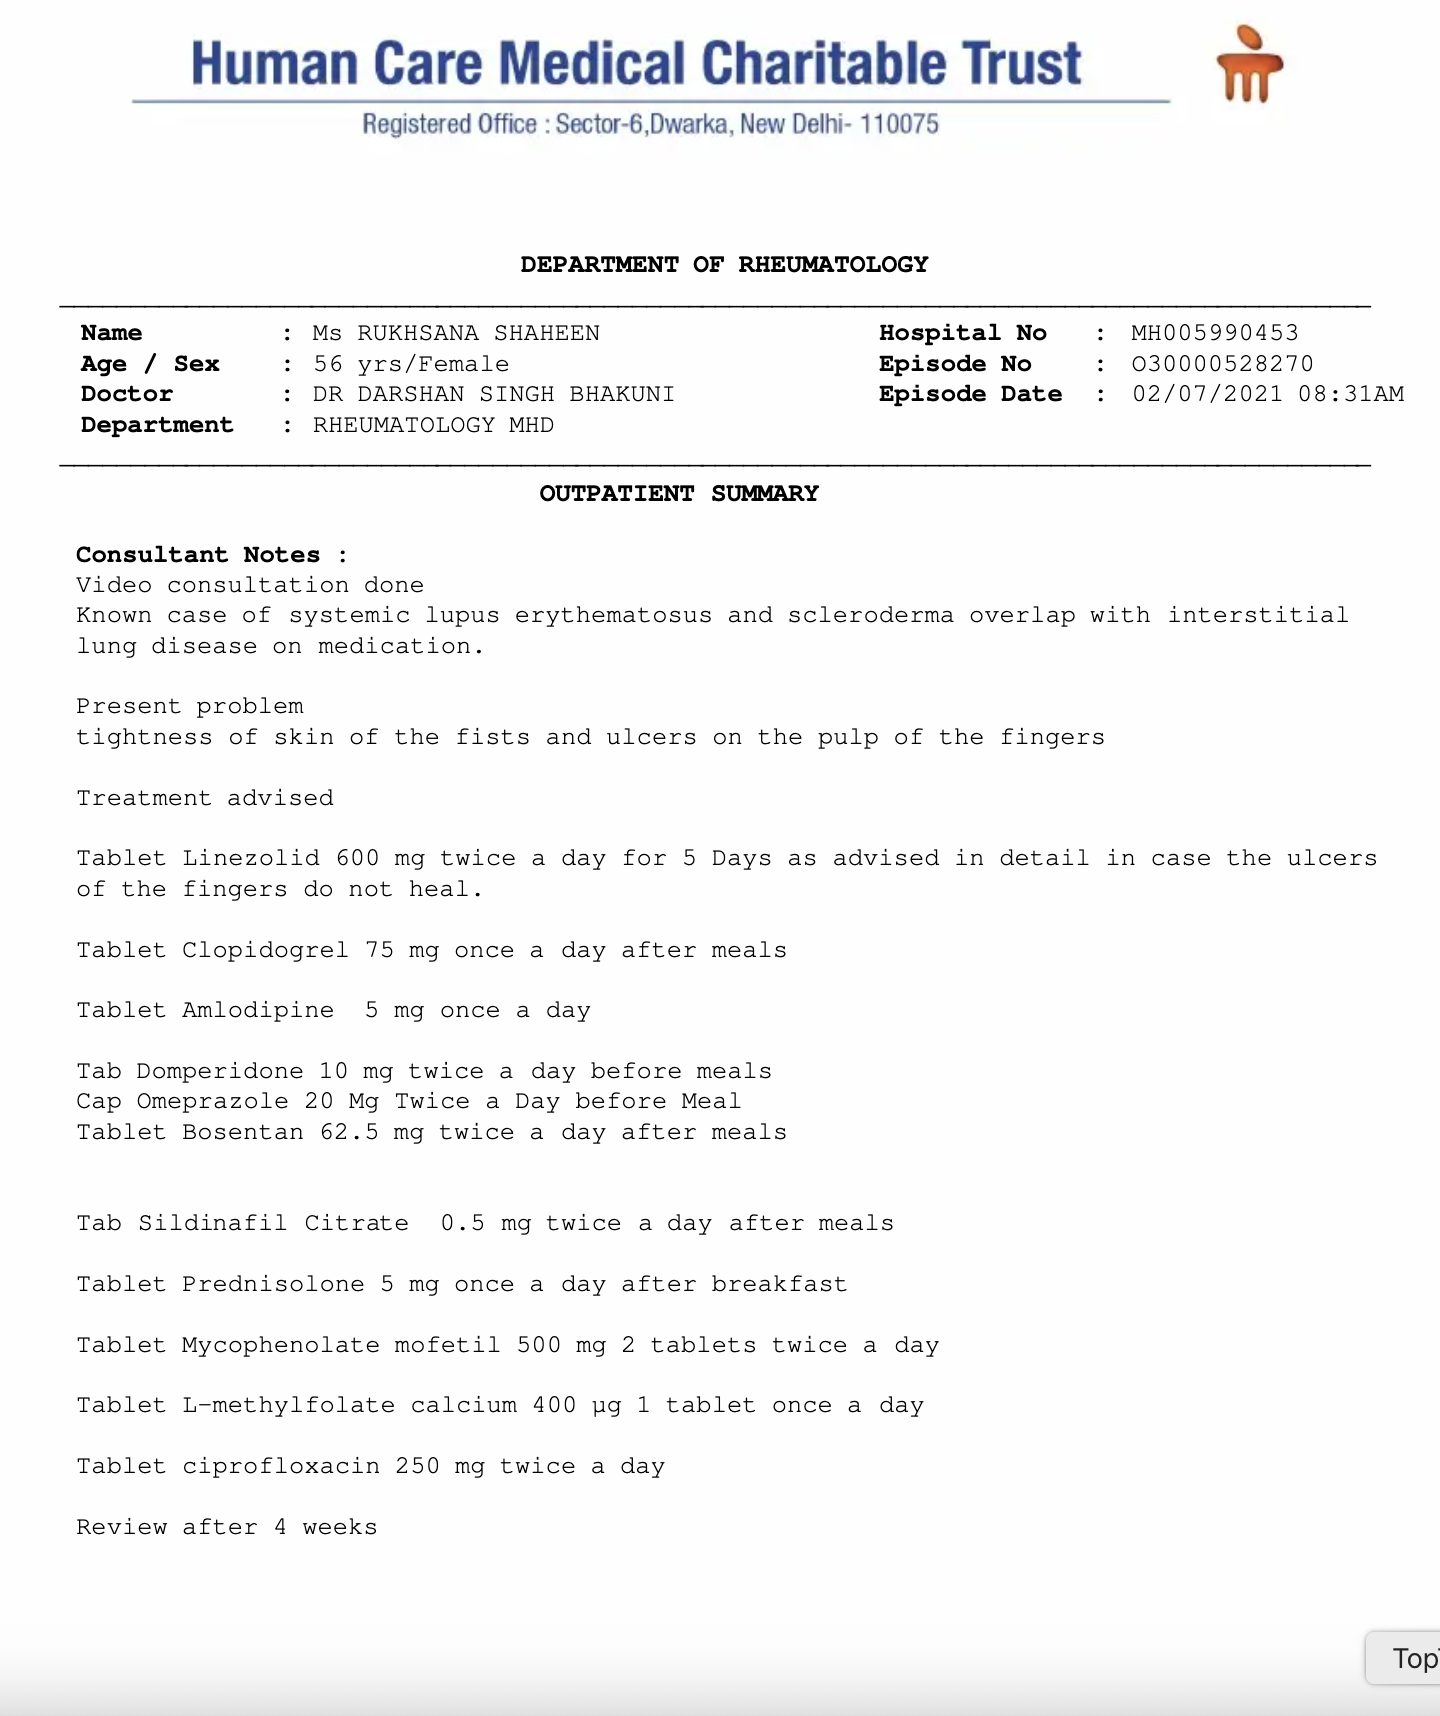

In [ ]:
from IPython.display import Image, display

display(Image(filename="./images/prescription.png"))

# Vision LLMs

## JSL_MedS_VLM_3B_v1

In [ ]:
from sparknlp_jsl.utils import *

prompt = """Extract demographic, clinical disease and medication informations"""

input_df = vision_llm_preprocessor(
    spark=spark,
    images_path="./images",
    prompt=prompt,
    output_col_name="prompt"
)
input_df.show()

+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|               image|                path|    modificationTime|length|             content|              prompt|
+--------------------+--------------------+--------------------+------+--------------------+--------------------+
|{file:/content/im...|file:/content/ima...|2025-08-11 09:43:...|466304|[89 50 4E 47 0D 0...|Extract demografi...|
+--------------------+--------------------+--------------------+------+--------------------+--------------------+



In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol("prompt")\
    .setOutputCol("document")

image_assembler = ImageAssembler()\
    .setInputCol("image")\
    .setOutputCol("image_assembler")

medical_vision_llm = MedicalVisionLLM.pretrained("jsl_meds_vlm_3b_q8_v1", "en", "clinical/models")\
    .setInputCols(["document", "image_assembler"])\
    .setOutputCol("completions")\
    .setChatTemplate("")\
    .setBatchSize(4)\
    .setNGpuLayers(99)\
    .setNCtx(4096)\
    .setNPredict(512)\
    .setTemperature(0.0)\
    .setTopK(1)\
    .setTopP(1)\
    .setRepeatLastN(256)\
    .setRepeatPenalty(1.1)\
    .setStopStrings(["</s>", "User:", "<|im_start|>"])


pipeline = Pipeline().setStages([
    document_assembler,
    image_assembler,
    medical_vision_llm
])


jsl_meds_vlm_3b_q8_v1 download started this may take some time.
Approximate size to download 3.6 GB
[OK!]


In [ ]:
%%time
result = pipeline.fit(input_df).transform(input_df).cache()

result.selectExpr(
    "reverse(split(image.origin, '/')) as image_name", "completions.result"
).show(truncate=False)

+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|image_name                                |result                                                                                                                                                                                                                                                                                                                

In [ ]:
result.selectExpr("completions.result as llm_response").show()

+--------------------+
|        llm_response|
+--------------------+
|[The document pro...|
+--------------------+



In [ ]:
%%time
collectted_result = result.select("completions.result").collect()

CPU times: user 1.56 ms, sys: 15 µs, total: 1.58 ms
Wall time: 50.6 ms


In [ ]:
for res in collectted_result:
    print("****"*10)
    print(res[0][0])

****************************************
The document provides the following information:

Demographic Information:
- Name: Ms Rukhsana Shaheen
- Age: 56 yrs
- Sex: Female

Clinical Disease Information:
- Systemic Lupus Erythematosus (SLE)
- Scleroderma overlap with interstitial lung disease on medication.

Medication Information:
- Prednisolone 10 mg twice a day before meals
- Mycophenolate mofetil 500 mg two tablets twice a day after breakfast
- L-methylfolate calcium 400 µg one tablet once a day
- Clopidogrel 75 mg once a day
- Amlodipine 5 mg once a day
- Ciprofloxacin 250 mg twice a day
- Review after 4 weeks


## JSL_MedS_VLM_2B_v1

In [ ]:
prompt = """
# Template:
{
  "Patient Name": "string",
  "Patient Age": "integer",
  "Patient Gender": "string",
  "Hospital Number": "string",
  "Episode Number": "string",
  "Episode Date": "date-time"
}
# Context:
<image>
"""

input_df = vision_llm_preprocessor(
    spark=spark,
    images_path="images",
    prompt=prompt,
    output_col_name="prompt"
)

document_assembler = DocumentAssembler()\
    .setInputCol("prompt")\
    .setOutputCol("document")

image_assembler = ImageAssembler()\
    .setInputCol("image")\
    .setOutputCol("image_assembler")

medical_vision_llm = MedicalVisionLLM.pretrained("jsl_meds_ner_vlm_2b_q16_v1", "en", "clinical/models")\
    .setInputCols(["document", "image_assembler"])\
    .setOutputCol("completions")\
    .setChatTemplate("")\
    .setBatchSize(4)\
    .setNGpuLayers(99)\
    .setNCtx(4096)\
    .setNPredict(512)\
    .setTemperature(0.0)\
    .setTopK(1)\
    .setTopP(1)\
    .setRepeatLastN(256)\
    .setRepeatPenalty(1.1)\
    .setStopStrings(["</s>", "User:", "<|im_start|>"])

pipeline = Pipeline().setStages([
    document_assembler,
    image_assembler,
    medical_vision_llm
])

jsl_meds_ner_vlm_2b_q16_v1 download started this may take some time.
Approximate size to download 3.3 GB
[OK!]


In [ ]:
%%time
result = pipeline.fit(input_df).transform(input_df).cache()

result.selectExpr(
    "reverse(split(image.origin, '/')) as image_name", "completions.result"
).show(truncate=False)

+------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|image_name                                |result                                                                                                                                                                                             |
+------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[prescription.png, images, content, file:]|[{"Patient Name": "Ms RUKHSANA SHAHEEN", "Patient Age": 56, "Patient Gender": "Female", "Hospital Number": "MH005990453", "Episode Number": "030000528270", "Episode Date": "2021-07-02T08:31:00"}]|
+-----------------------------------

In [ ]:
result.selectExpr("completions.result as llm_response").show()

+--------------------+
|        llm_response|
+--------------------+
|[{"Patient Name":...|
+--------------------+



In [ ]:
collectted_result = result.select("completions.result").collect()

In [ ]:
for res in collectted_result:
    print("****"*10)
    print(res[0][0])

****************************************
{"Patient Name": "Ms RUKHSANA SHAHEEN", "Patient Age": 56, "Patient Gender": "Female", "Hospital Number": "MH005990453", "Episode Number": "030000528270", "Episode Date": "2021-07-02T08:31:00"}


## JSL_MedS_VLM_2B_v2

In [ ]:
prompt = """
# Template:
{
  "Patient Name": "string",
  "Patient Age": "integer",
  "Patient Gender": "string",
  "Hospital Number": "string",
  "Episode Number": "string",
  "Episode Date": "date-time"
}
# Context:
<image>
"""

input_df = vision_llm_preprocessor(
    spark=spark,
    images_path="images",
    prompt=prompt,
    output_col_name="prompt"
)

document_assembler = DocumentAssembler()\
    .setInputCol("prompt")\
    .setOutputCol("document")

image_assembler = ImageAssembler()\
    .setInputCol("image")\
    .setOutputCol("image_assembler")

medical_vision_llm = MedicalVisionLLM.pretrained("jsl_meds_ner_vlm_2b_q16_v2", "en", "clinical/models")\
    .setInputCols(["document", "image_assembler"])\
    .setOutputCol("completions")\
    .setChatTemplate("")\
    .setBatchSize(4)\
    .setNGpuLayers(99)\
    .setNCtx(4096)\
    .setNPredict(512)\
    .setTemperature(0.0)\
    .setTopK(1)\
    .setTopP(1)\
    .setRepeatLastN(256)\
    .setRepeatPenalty(1.1)\
    .setStopStrings(["</s>", "User:", "<|im_start|>"])

pipeline = Pipeline().setStages([
    document_assembler,
    image_assembler,
    medical_vision_llm
])

jsl_meds_ner_vlm_2b_q16_v2 download started this may take some time.
Approximate size to download 3.3 GB
[OK!]


In [ ]:
%%time
result = pipeline.fit(input_df).transform(input_df).cache()

result.selectExpr(
    "reverse(split(image.origin, '/')) as image_name", "completions.result"
).show(truncate=False)

+------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|image_name                                |result                                                                                                                                                                                             |
+------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[prescription.png, images, content, file:]|[{"Patient Name": "Ms RUKHSANA SHAHEEN", "Patient Age": 56, "Patient Gender": "Female", "Hospital Number": "MH005990453", "Episode Number": "030000528270", "Episode Date": "2021-07-02T08:31:00"}]|
+-----------------------------------

In [ ]:
result.selectExpr("completions.result as llm_response").show()

+--------------------+
|        llm_response|
+--------------------+
|[{"Patient Name":...|
+--------------------+



In [ ]:
collectted_result = result.select("completions.result").collect()

In [ ]:
for res in collectted_result:
    print("****"*10)
    print(res[0][0])

****************************************
{"Patient Name": "Ms RUKHSANA SHAHEEN", "Patient Age": 56, "Patient Gender": "Female", "Hospital Number": "MH005990453", "Episode Number": "030000528270", "Episode Date": "2021-07-02T08:31:00"}
